# NN from scratch with Titanic data set

In [1]:
import torch, numpy as np, pandas as pd
df = pd.read_csv("train.csv")
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [2]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [3]:
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [4]:
# log of fare 
df['LogFare'] = np.log(df['Fare']+1)

In [5]:
df["Sex_orig"] = df["Sex"]
df["Embarked_orig"] = df["Embarked"]
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'LogFare', 'Sex_orig', 'Embarked_orig', 'Sex_female',
       'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [6]:
from torch import tensor

# dependent variable Y is survived 
t_dep = tensor(df["Survived"])

# independent variably X are the rest (exclude str vars: name, ticket, cabin)
cols = ['Age', 'SibSp', 'Parch', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

t_indep = tensor(df[cols].astype(float).values, dtype=torch.float)
t_indep

tensor([[22.,  1.,  0.,  ...,  0.,  0.,  1.],
        [38.,  1.,  0.,  ...,  1.,  0.,  0.],
        [26.,  0.,  0.,  ...,  0.,  0.,  1.],
        ...,
        [24.,  1.,  2.,  ...,  0.,  0.,  1.],
        [26.,  0.,  0.,  ...,  1.,  0.,  0.],
        [32.,  0.,  0.,  ...,  0.,  1.,  0.]])

In [7]:
df[["Embarked_C","Embarked_Q"]].astype(int)

df[cols].head()

,Age,SibSp,Parch,LogFare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,2.110213,False,True,False,False,True,False,False,True
1,38.0,1,0,4.280593,True,False,True,False,False,True,False,False
2,26.0,0,0,2.188856,True,False,False,False,True,False,False,True
3,35.0,1,0,3.990834,True,False,True,False,False,False,False,True
4,35.0,0,0,2.202765,False,True,False,False,True,False,False,True


## Linear Model with OLS

Remember: 
$
(X'X)^{-1} X'y
$

In [8]:
ones = np.ones( (len(t_indep),1) )

cols_lin = ['Age', 'SibSp', 'Parch', 'LogFare', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_Q']

t_indep_lin = tensor(df[cols_lin].astype(float).values, dtype=torch.float)

# normalizing the data to 0-1
X = np.array(t_indep_lin)/np.array(t_indep_lin).max(axis=0) 

# add a constant
X_ = np.append( ones ,X ,axis=1)
y = np.array(t_dep)

ols_coeffs = np.linalg.inv(X_.T.dot(X_)).dot(X_.T.dot(y))
ols_coeffs = dict(zip( ["const"]+cols , ols_coeffs))
ols_coeffs

{'const': 0.11559358731563174,
 'Age': -0.43796276520597033,
 'SibSp': -0.42575415344404144,
 'Parch': -0.15299384598866084,
 'LogFare': 0.36158618366199313,
 'Sex_female': 0.4966591016175076,
 'Sex_male': 0.26706475935619434,
 'Pclass_1': 0.17140372706538098,
 'Pclass_2': 0.05764348241644503,
 'Pclass_3': 0.05248836482084218}

In [9]:
from sklearn import linear_model
import statsmodels.api as sm

reg = linear_model.LinearRegression()
reg.fit(X,y)
sk_coeffs = dict(zip( cols , reg.coef_))
print(sk_coeffs)

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

{'Age': -0.4379627, 'SibSp': -0.42575437, 'Parch': -0.15299393, 'LogFare': 0.36158618, 'Sex_female': 0.49665877, 'Sex_male': 0.26706472, 'Pclass_1': 0.17140378, 'Pclass_2': 0.05764336, 'Pclass_3': 0.05248855}
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     65.35
Date:                Thu, 07 Mar 2024   Prob (F-statistic):           9.56e-92
Time:                        20:36:47   Log-Likelihood:                -394.14
No. Observations:                 891   AIC:                             808.3
Df Residuals:                     881   BIC:                             856.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
 

## Setting up the NN 

In [10]:
# normalizing the data to 0-1
t_indep = t_indep/t_indep.max(dim=0).values
t_indep

tensor([[0.2750, 0.1250, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.3000, 0.1250, 0.3333,  ..., 0.0000, 0.0000, 1.0000],
        [0.3250, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.4000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000]])

In [11]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,
         0.2799, -0.4392,  0.2103,  0.3625])

In [12]:
preds = (t_indep*coeffs).sum(axis=1)
loss = torch.abs(preds-t_dep).mean() # absolute mean error
loss

tensor(0.5200)

In [13]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

In [14]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,
         0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [15]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5200, grad_fn=<MeanBackward0>)

In [16]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5056)


## training the model

In [17]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

In [18]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [19]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [20]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

In [21]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [22]:
coeffs = train_model(18, lr=0.2)

0.518; 0.491; 0.468; 0.445; 0.422; 0.400; 0.378; 0.358; 0.340; 0.327; 0.315; 0.306; 0.308; 0.311; 0.311; 0.292; 0.296; 0.287; 

In [23]:
def show_coeffs(): return dict(zip(cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2581),
 'SibSp': tensor(0.0894),
 'Parch': tensor(0.2346),
 'LogFare': tensor(0.0275),
 'Sex_female': tensor(0.2574),
 'Sex_male': tensor(-0.4129),
 'Pclass_1': tensor(0.7098),
 'Pclass_2': tensor(0.4246),
 'Pclass_3': tensor(0.3691),
 'Embarked_C': tensor(0.0955),
 'Embarked_Q': tensor(0.2490),
 'Embarked_S': tensor(0.2116)}

In [24]:
sk_coeffs

{'Age': -0.4379627,
 'SibSp': -0.42575437,
 'Parch': -0.15299393,
 'LogFare': 0.36158618,
 'Sex_female': 0.49665877,
 'Sex_male': 0.26706472,
 'Pclass_1': 0.17140378,
 'Pclass_2': 0.05764336,
 'Pclass_3': 0.05248855}

In [25]:
ols_coeffs

{'const': 0.11559358731563174,
 'Age': -0.43796276520597033,
 'SibSp': -0.42575415344404144,
 'Parch': -0.15299384598866084,
 'LogFare': 0.36158618366199313,
 'Sex_female': 0.4966591016175076,
 'Sex_male': 0.26706475935619434,
 'Pclass_1': 0.17140372706538098,
 'Pclass_2': 0.05764348241644503,
 'Pclass_3': 0.05248836482084218}

In [26]:
ols_coeffs_pd = pd.DataFrame.from_dict(
{'const': [0.11559358731563174],
 'Age': [-0.43796276520597033],
 'SibSp': [-0.42575415344404144],
 'Parch': [-0.15299384598866084],
 'LogFare': [0.36158618366199313],
 'Sex_female': [0.4966591016175076],
 'Pclass_1': [0.26706475935619434],
 'Pclass_2': [0.17140372706538098],
 'Embarked_C': [0.05764348241644503],
 'Embarked_Q': [0.05248836482084218]}    
)

In [27]:
# try to get the predictions and see if they are between 0 and 1.
# the matrix is normalized to 0-1 and  therefore the data frame should also be normalized

np.multiply(df[["Age","LogFare"]].values,ols_coeffs_pd[["Age","LogFare"]].values).sum(axis=1)[0:10]

array([ -8.8721569 , -15.09478175, -10.59557169, -13.88566628,
       -14.53220748,  -9.69866102, -22.21532592,   0.2429833 ,
       -10.92249227,  -4.88897151])

# Try a random forest with the titatnic data set

In [28]:
from sklearn.tree import DecisionTreeClassifier

m = DecisionTreeClassifier(max_leaf_nodes=10).fit(df[cols], df["Survived"]);
m

DecisionTreeClassifier(max_leaf_nodes=10)

[Text(0.5357142857142857, 0.9166666666666666, 'x[4] <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]'),
 Text(0.2857142857142857, 0.75, 'x[0] <= 6.5\ngini = 0.306\nsamples = 577\nvalue = [468, 109]'),
 Text(0.14285714285714285, 0.5833333333333334, 'x[1] <= 2.5\ngini = 0.444\nsamples = 24\nvalue = [8, 16]'),
 Text(0.07142857142857142, 0.4166666666666667, 'gini = 0.0\nsamples = 15\nvalue = [0, 15]'),
 Text(0.21428571428571427, 0.4166666666666667, 'gini = 0.198\nsamples = 9\nvalue = [8, 1]'),
 Text(0.42857142857142855, 0.5833333333333334, 'x[6] <= 0.5\ngini = 0.28\nsamples = 553\nvalue = [460, 93]'),
 Text(0.35714285714285715, 0.4166666666666667, 'gini = 0.204\nsamples = 433\nvalue = [383, 50]'),
 Text(0.5, 0.4166666666666667, 'x[3] <= 3.301\ngini = 0.46\nsamples = 120\nvalue = [77, 43]'),
 Text(0.42857142857142855, 0.25, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(0.5714285714285714, 0.25, 'x[0] <= 53.0\ngini = 0.476\nsamples = 110\nvalue = [67, 43]'),
 Text(0.5, 0.0833333

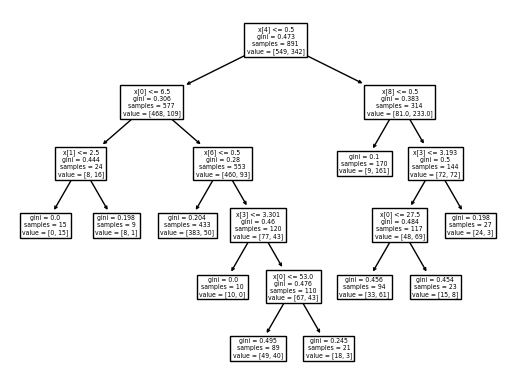

In [29]:
from sklearn import tree
tree.plot_tree(m)

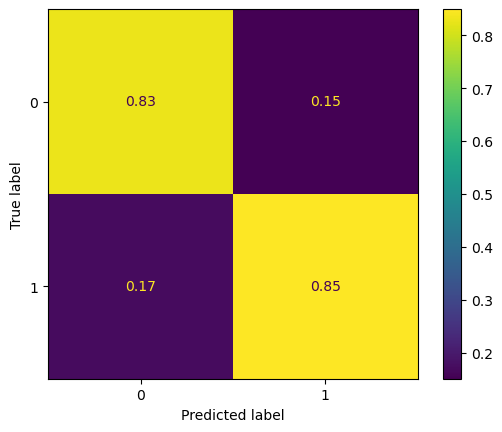

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(m, df[cols], df["Survived"],normalize="pred")

In [38]:
cats = ["Sex","Embarked"]
pd.Categorical(df["Sex_orig"]).categories#.codes

Index(['female', 'male'], dtype='object')

In [41]:
pd.Categorical(df["Sex_orig"]).codes[0:10]

array([1, 0, 0, 0, 1, 1, 1, 1, 0, 0], dtype=int8)